In [1]:

import librosa
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
from google.colab import drive
drive.mount('/content/drive')
train=np.load("./drive/My Drive/audio_train.npy")
test=np.load("./drive/My Drive/audio_test.npy")
train_labels=pd.read_csv("./drive/My Drive/labels_train.csv")
sample_submission=pd.read_csv("./drive/My Drive/sample_submission.csv")
label = list(train_labels['label'])

y_train = np.empty([len(train),1])
for i in range(len(label)):
  y_train[i] = label[i]
y_train = np.array(y_train, dtype='uint8')

num_classes = 10
y_train = keras.utils.to_categorical(y_train, num_classes)

Mounted at /content/drive


In [4]:
# Preprocessing
def audio2spectrogram(wave:np.array, sr:int, n_mels:int=128) -> np.array:
    """
    @topic: Convert 1-D audio wave to 2-D spectrogram.
    @topic: wave: audio wave; sr: sample rate; n_mels: the size of output spectrogram.
    @return: 2-D spectrogram.
    @ref: https://blog.csdn.net/zzc15806/article/details/79603994
    """
    spec = librosa.feature.melspectrogram(y=wave, sr=sr, n_mels=n_mels)
    logspec = librosa.power_to_db(spec) # convert to log value
    return logspec

def MinMaxScaler(data, low, high):
    """
    @topic: Rescale 2D matrix into given ranges.
    @parameters: data (2d matrix), low/high (Scalar).
    @return: scaled data (2d matrix).
    """
    data_max, data_min = data.max(axis=0), data.min(axis=0)
    data_std = (data - data_min) / (data_max - data_min + 0.00001)
    data_scaled = data_std * (high - low) + low
    return data_scaled

def pad_image(img, row_new=64, col_new=64):
    # Pad the cropped image
    row_old, col_old = img.shape[0], img.shape[1] # 旧照片尺寸
    img_new = np.zeros((row_new, col_new)) # 初始化新照片
    # Compute the padding offset (照片新增的边缘部分)
    row_offset = (row_new - row_old) // 2
    col_offset = (col_new - col_old) // 2
    # Copy the old image into center of new image
    img_new[row_offset:row_offset+row_old, col_offset:col_offset+col_old] = img
    # Fill the background color
    bg_px = img.min() # 设定背景
    for i in range(len(img_new)):
        for j in range(len(img_new[i])):
            if img_new[i][j] == 0: # 将填充部分改为相似的背景
                img_new[i][j] = bg_px
    return img_new

def get_spectrogram_data(data:np.array, sr:int, n_mels:int=59) -> np.array:
    """
    @topic: Convert 1-D audio wave to 2-D spectrogram and build 4-D dataset.
    @topic: wave: audio wave; sr: sample rate; n_mels: the size of output spectrogram.
    @return: 4-D spectrogram dataset (n_samples, rows, cols, channels).
    """
    data_sp = []
    for i in range(len(data)):
        logspec_i = audio2spectrogram(data[i], sr, n_mels)
        logspec_i_pad = pad_image(logspec_i, row_new=64, col_new=64)
        data_sp.append(logspec_i_pad)
    data_sp = np.expand_dims(np.array(data_sp), axis=-1) # add 1 dim
    return data_sp.astype("float32")

def gen_synthetic_data(model, BATCH_SIZE, LATENT_DIM):
    # Generate synthetic samples from random embeddings.
    z = tf.random.normal([BATCH_SIZE, LATENT_DIM], dtype='float32') # Generate some random embeddings
    predictions = model.sample(z) # generate synthetic samples
    return predictions

In [5]:
# Build CVAE model
class CVAE(tf.keras.Model):
    """Convolutional variational autoencoder."""
    def __init__(self, n_rows, n_cols, n_channels, n_latent_dim):
        super(CVAE, self).__init__()
        self.rows = n_rows
        self.cols = n_cols
        self.channels = n_channels
        self.latent_dim = n_latent_dim

        self.encoder = tf.keras.Sequential(
            [tf.keras.layers.InputLayer(input_shape=(self.rows, self.cols, self.channels)),
            tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(self.latent_dim + self.latent_dim),]) # No activation

        self.decoder = tf.keras.Sequential(
            [tf.keras.layers.InputLayer(input_shape=(self.latent_dim,)),
            tf.keras.layers.Dense(units=(self.rows//4)*(self.cols//4)*32, activation=tf.nn.relu), 
            tf.keras.layers.Reshape(target_shape=(self.rows//4, self.cols//4, 32)), # 16x16x32
            tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding='same', activation='relu'),
            tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding='same', activation='relu'),
            tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=3, strides=1, padding='same'),]) # No activation

    @tf.function
    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(100, self.latent_dim))
        return self.decode(eps, apply_sigmoid=True)

    def encode(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean

    def decode(self, z, apply_sigmoid=False):
        logits = self.decoder(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits


In [6]:
# Training
def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2. * np.pi)
    return tf.reduce_sum(-.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi), axis=raxis)

def compute_loss(model, x):
    mean, logvar = model.encode(x)
    z = model.reparameterize(mean, logvar)
    x_logit = model.decode(z)
    cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
    logpx_z = -tf.reduce_sum(cross_entropy, axis=[1, 2, 3])
    logpz = log_normal_pdf(z, 0., 0.)
    logqz_x = log_normal_pdf(z, mean, logvar)
    return -tf.reduce_mean(logpx_z + logpz - logqz_x)

@tf.function
def train_step(model, x, optimizer):
    """Executes one training step and returns the loss.
    This function computes the loss and gradients, 
    and uses the latter to update the model's parameters.
    """
    with tf.GradientTape() as tape:
        loss = compute_loss(model, x)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

def train(X_train, N_EPOCHS, model, optimizer):
    for epoch in range(1, N_EPOCHS+1):
        start_time = time.time()
        #loss = tf.keras.metrics.Mean()
        for x in X_train:
            train_step(model, x, optimizer)
            #loss(compute_loss(model, x))
        #elbo = -loss.result()
        end_time = time.time()
        #print('Epoch {0}: ELBO is {1} and Time elapse is {2}.'
            #.format(epoch, elbo, end_time - start_time))
        print('In Epoch {0}, Time elapse: {1}.'
            .format(epoch, end_time - start_time))


In [7]:
# Plotting
def gen_latent_data(model, data):
    # Generate latent data (np.array) from given dataset
    mean, logvar = model.encode(data)
    z = model.reparameterize(mean, logvar)
    return z.numpy()

def plot_latent_data(model, data, label):
    # Plot the latent data on 2D plane.
    color_list = ['or', 'ob', 'og', 'ok', '^r', '+r', 'sr', 'dr', '<r', 'pr']
    z = gen_latent_data(model, data) # convert to np.array before plotting
    for i in range(len(label)):
        plt.plot(z[i,0], z[i,1], color_list[label[i]], markersize = 5)
    #plt.axis('off')
    plt.savefig('CVAE_scatter.png')
    plt.show()

In [8]:
if __name__ == '__main__':
    # Initialize the arguments
    try:
        N_EPOCHS = int(sys.argv[1])
        LATENT_DIM = int(sys.argv[2])
        WHICH_PART = int(sys.argv[3])
    except:
        N_EPOCHS = 100
        LATENT_DIM = 50 # set dim=2 to a plane for visualization  
        WHICH_PART = 2 # select the part of question
    ROWS = 64
    COLS = 64
    CHANNELS = 1
    sample_rate = 22050 # default
    BATCH_SIZE = 32
    LEARNING_RATE = 1e-4
    # Import audio dataset
    X_train = np.load("./drive/My Drive/audio_train.npy")
    X_test = np.load("./drive/My Drive/audio_test.npy")
    data = np.vstack((X_train, X_test)) # merge for clustering
    Y_train = pd.read_csv("./drive/My Drive/labels_train.csv")
    Y_train = np.array(Y_train)[:, -1] # set(Y_train) = {0, 1, 3, 4, 5, 6, 7, 8, 9}
    Y_test_fake = np.array([2 for i in range(len(X_test))])
    label = np.hstack((Y_train, Y_test_fake))
    print("X_train/X_test/data's shape: ", X_train.shape, X_test.shape, data.shape)
    if WHICH_PART == 3:
        data = X_train
    # Preprocessing
    data_sp = get_spectrogram_data(data, sample_rate, n_mels=59)
    data_scaled = MinMaxScaler(data_sp, -1, 1)
    TRAIN_SIZE = len(data_scaled)
    data_train = (tf.data.Dataset.from_tensor_slices(data_scaled)
                .shuffle(TRAIN_SIZE).batch(BATCH_SIZE)) # Shuffle the dataset
    # Define the optimizer
    optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)
    # Instantiate the model
    model = CVAE(ROWS, COLS, CHANNELS, LATENT_DIM)
    # Train the model
    train(data_train, N_EPOCHS, model, optimizer)
    # Part 1: Plotting the latent data on 2-D plane. (LATENT_DIM = 2)
    if WHICH_PART == 1:
        #z = gen_latent_data(model, data_scaled)
        #np.save("latent.npy", z)
        plot_latent_data(model, data_scaled, label)
        print("Plotting completed!")
    # Part 2: Generate synthetic audio by VAE
    if WHICH_PART == 2:
        X_pred = gen_synthetic_data(model, BATCH_SIZE, LATENT_DIM)
        np.save("synData.npy", X_pred)
        print("synData.npy generated!")
    # Part 3: Implement Random Forest Classifier as baseline
    if WHICH_PART == 3:
        from sklearn.ensemble import RandomForestClassifier
        data_encoded = gen_latent_data(model, data_scaled)
        rfc = RandomForestClassifier(oob_score=True, random_state=10)
        rfc.fit(data_encoded, Y_train)
        # Evaluation
        print("out-of-bag (OOB) score: ", rfc.oob_score_)

X_train/X_test/data's shape:  (942, 30000) (558, 30000) (1500, 30000)
In Epoch 1, Time elapse: 7.448915958404541.
In Epoch 2, Time elapse: 0.26457881927490234.
In Epoch 3, Time elapse: 0.25571775436401367.
In Epoch 4, Time elapse: 0.25513505935668945.
In Epoch 5, Time elapse: 0.2565634250640869.
In Epoch 6, Time elapse: 0.2583498954772949.
In Epoch 7, Time elapse: 0.25429725646972656.
In Epoch 8, Time elapse: 0.2541978359222412.
In Epoch 9, Time elapse: 0.25972747802734375.
In Epoch 10, Time elapse: 0.2564530372619629.
In Epoch 11, Time elapse: 0.25400614738464355.
In Epoch 12, Time elapse: 0.2529776096343994.
In Epoch 13, Time elapse: 0.25689029693603516.
In Epoch 14, Time elapse: 0.25455546379089355.
In Epoch 15, Time elapse: 0.2548050880432129.
In Epoch 16, Time elapse: 0.25628137588500977.
In Epoch 17, Time elapse: 0.25394701957702637.
In Epoch 18, Time elapse: 0.2518768310546875.
In Epoch 19, Time elapse: 0.25235509872436523.
In Epoch 20, Time elapse: 0.2536141872406006.
In Epoch 

In [14]:
pred = model.decode(Y_train)

InvalidArgumentError: ignored

In [15]:
syn=np.load("./synData.npy")

In [18]:
syn

array([[[[0.347996  ],
         [0.2463457 ],
         [0.25208762],
         ...,
         [0.21351382],
         [0.25208762],
         [0.3146599 ]],

        [[0.27028638],
         [0.12903652],
         [0.13448283],
         ...,
         [0.09122295],
         [0.13448283],
         [0.1951876 ]],

        [[0.26211378],
         [0.12678494],
         [0.13003597],
         ...,
         [0.09223853],
         [0.13003597],
         [0.20132674]],

        ...,

        [[0.24063545],
         [0.09810904],
         [0.10098752],
         ...,
         [0.06281823],
         [0.10098752],
         [0.15674661]],

        [[0.26211378],
         [0.12678494],
         [0.13003597],
         ...,
         [0.09223853],
         [0.13003597],
         [0.20132674]],

        [[0.3301173 ],
         [0.21710792],
         [0.21159783],
         ...,
         [0.17506355],
         [0.21159783],
         [0.2717229 ]]],


       [[[0.347996  ],
         [0.2463457 ],
         [0.25

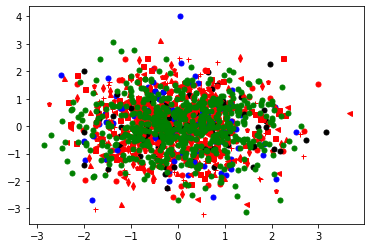

Plotting completed!


In [ ]:
        plot_latent_data(model, data_scaled, label)
        print("Plotting completed!")

In [ ]:
        X_pred = gen_synthetic_data(model, BATCH_SIZE, LATENT_DIM)
        np.save("synData.npy", X_pred)
        print("synData.npy generated!")

synData.npy generated!


In [ ]:
data_encoded = gen_latent_data(model, data_scaled)

In [ ]:
  from sklearn.ensemble import RandomForestClassifier
  data_encoded = gen_latent_data(model, data_scaled)
  rfc = RandomForestClassifier(oob_score=True, random_state=10)
  rfc.fit(data_encoded, Y_train)
  # Evaluation
  print("out-of-bag (OOB) score: ", rfc.oob_score_)

ValueError: ignored